In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# visualization style
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [17]:
print("1. Data loading...")
try: 
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    print("Data load complete.")
except FileNotFoundError:
    print("Can not found file.")
    
print(train_df.head())
print("--------------------------------")
print(test_df.head())

1. Data loading...
Data load complete.
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
--------------------------------
              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66 

In [18]:
print(train_df.info())
print("--------------------------------")
print(train_df.describe())
print("--------------------------------")
print(train_df.isnull().sum())
print("--------------------------------")
print(train_df.head())
print("--------------------------------")
print(train_df.tail())
print("--------------------------------")
print(train_df.shape)
print("--------------------------------")

# datetime: Date and time of the rental
# season: Season information
# holiday: Whether the day is a public holiday (1 = yes, 0 = no)
# workingday: Whether the day is a working day (1 = yes, 0 = no)
# weather: Weather condition
#   1: Clear or partly cloudy
#   2: Mist or cloudy
#   3: Light snow/rain or thunderstorm
#   4: Heavy rain/snow or fog
# temp: Temperature (°C)
# atemp: Feels-like temperature (°C)
# humidity: Humidity (%)
# windspeed: Wind speed (m/s)
# casual: Number of rentals by casual (non-registered) users
# registered: Number of rentals by registered users
# count: Total number of rentals (casual + registered)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
--------------------------------
             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418

In [19]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

In [20]:
train_df['year'] = train_df['datetime'].dt.year
test_df['year'] = test_df['datetime'].dt.year

train_df['month'] = train_df['datetime'].dt.month
test_df['month'] = test_df['datetime'].dt.month

train_df['day'] = train_df['datetime'].dt.day
test_df['day'] = test_df['datetime'].dt.day

train_df['hour'] = train_df['datetime'].dt.hour
test_df['hour'] = test_df['datetime'].dt.hour

train_df['dayofweek'] = train_df['datetime'].dt.dayofweek
test_df['dayofweek'] = test_df['datetime'].dt.dayofweek

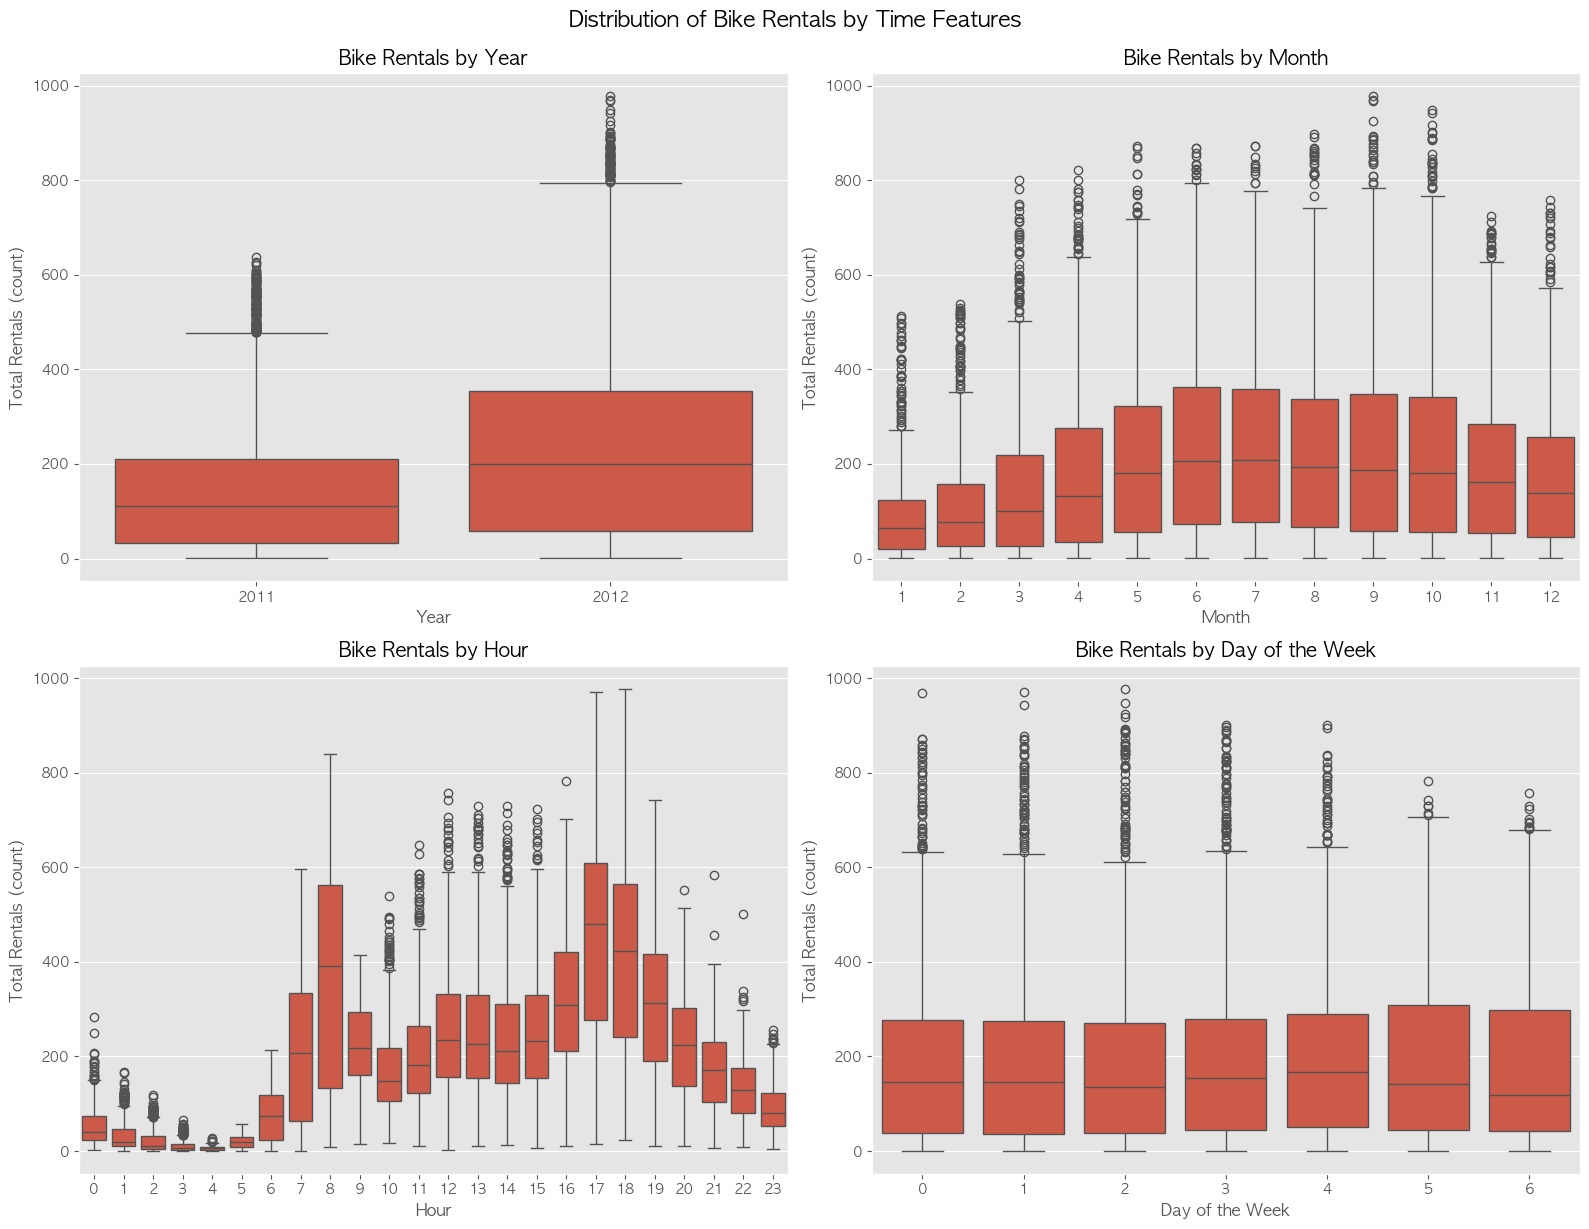

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

sns.boxplot(data=train_df, x='year', y='count', ax=axes[0, 0])
axes[0, 0].set_title('Bike Rentals by Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Total Rentals (count)')

sns.boxplot(data=train_df, x='month', y='count', ax=axes[0, 1])
axes[0, 1].set_title('Bike Rentals by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Total Rentals (count)')

sns.boxplot(data=train_df, x='hour', y='count', ax=axes[1, 0])
axes[1, 0].set_title('Bike Rentals by Hour')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Total Rentals (count)')

sns.boxplot(data=train_df, x='dayofweek', y='count', ax=axes[1, 1])
axes[1, 1].set_title('Bike Rentals by Day of the Week')
axes[1, 1].set_xlabel('Day of the Week')
axes[1, 1].set_ylabel('Total Rentals (count)')

plt.tight_layout()
plt.suptitle('Distribution of Bike Rentals by Time Features', y=1.02, fontsize=16)
plt.show()

In [22]:
train_df[train_df['humidity'] == 0]

# eliminate humidity 0
train_df = train_df[train_df['humidity'] != 0]

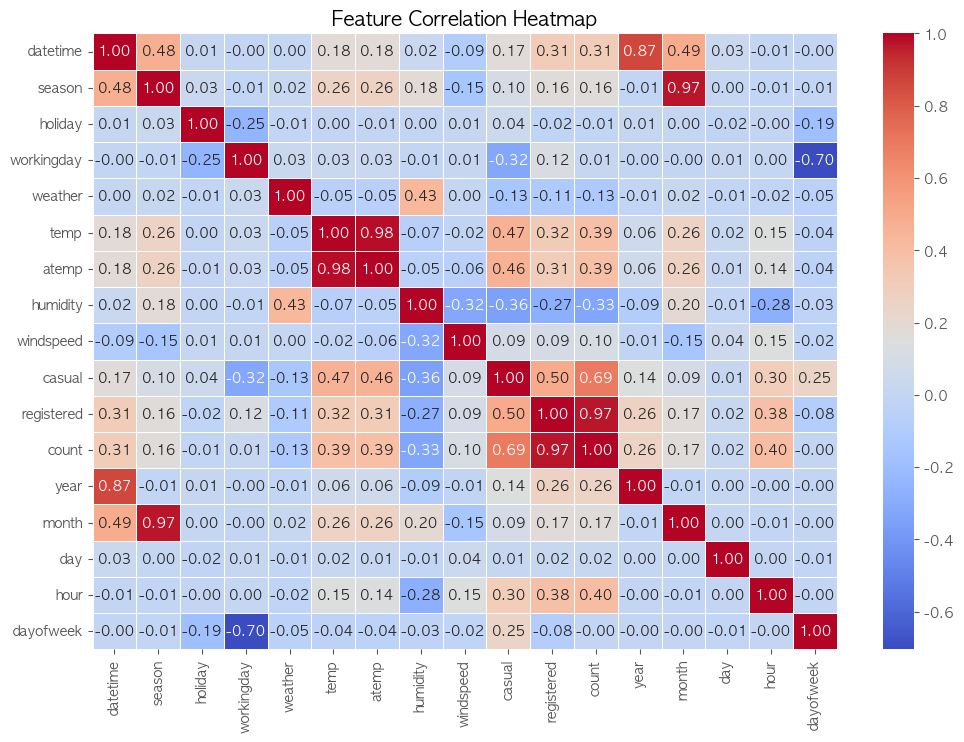

In [23]:
corr_matrix = train_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [24]:
features_to_drop = ['datetime', 'casual', 'registered', 'atemp', 'day', 'dayofweek']
train_df_processed = train_df.drop(features_to_drop, axis=1)
test_df_processed = test_df.drop(['datetime', 'atemp', 'day', 'dayofweek'], axis=1)

In [25]:
X = train_df_processed.drop('count', axis=1)
y = train_df_processed['count']

In [26]:
y_log = np.log1p(train_df_processed['count'])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2)

xgb_reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=10,
)

In [28]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=True)

[0]	validation_0-rmse:1.37355
[1]	validation_0-rmse:1.31714
[2]	validation_0-rmse:1.26452
[3]	validation_0-rmse:1.21505
[4]	validation_0-rmse:1.16765
[5]	validation_0-rmse:1.12369
[6]	validation_0-rmse:1.08214
[7]	validation_0-rmse:1.04303
[8]	validation_0-rmse:1.00562
[9]	validation_0-rmse:0.97005
[10]	validation_0-rmse:0.93762
[11]	validation_0-rmse:0.90572
[12]	validation_0-rmse:0.87556
[13]	validation_0-rmse:0.84542
[14]	validation_0-rmse:0.81807
[15]	validation_0-rmse:0.79361
[16]	validation_0-rmse:0.76999
[17]	validation_0-rmse:0.74837
[18]	validation_0-rmse:0.72534
[19]	validation_0-rmse:0.70610
[20]	validation_0-rmse:0.68761
[21]	validation_0-rmse:0.67069
[22]	validation_0-rmse:0.65493
[23]	validation_0-rmse:0.63827
[24]	validation_0-rmse:0.62476
[25]	validation_0-rmse:0.60988
[26]	validation_0-rmse:0.59785
[27]	validation_0-rmse:0.58500
[28]	validation_0-rmse:0.57426
[29]	validation_0-rmse:0.56421
[30]	validation_0-rmse:0.55307
[31]	validation_0-rmse:0.54390
[32]	validation_0-

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,10
,enable_categorical,False
,eval_metric,None


In [29]:
y_pred_log = xgb_reg.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test)

In [30]:
y_pred[y_pred < 0] = 0

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

rmsle_score = rmsle(y_test, y_pred)
print(f"RMSLE: {rmsle_score:.4f}")

RMSLE: 0.3116


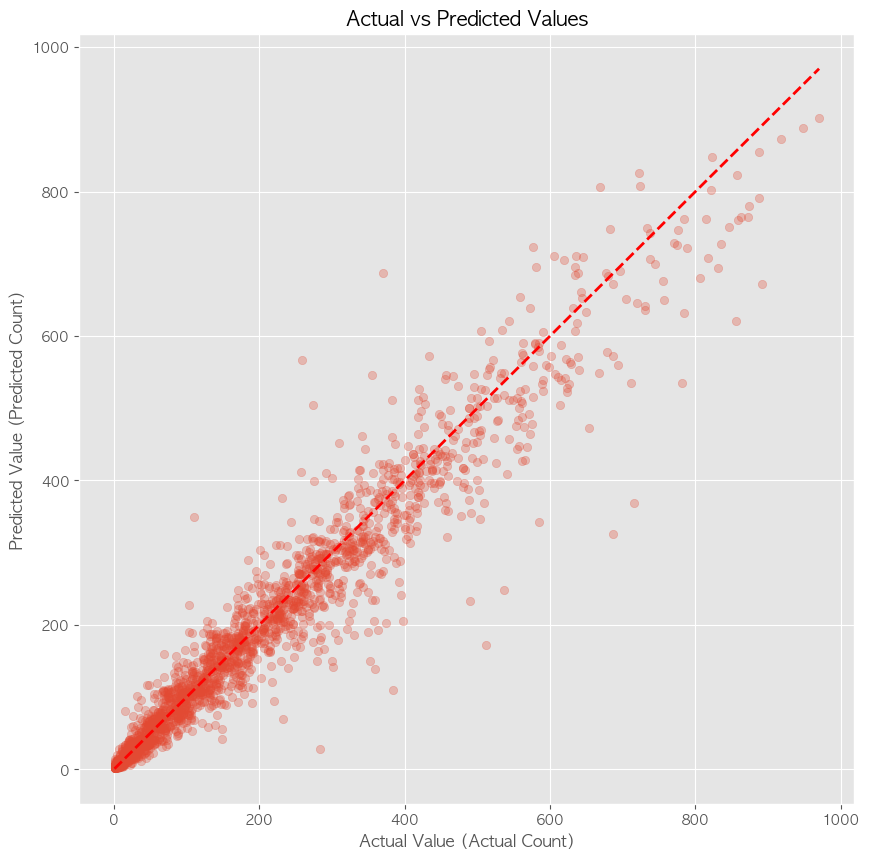

 - Visualization of Actual vs Predicted Values Completed


In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
plt.xlabel("Actual Value (Actual Count)")
plt.ylabel("Predicted Value (Predicted Count)")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.show()
print(" - Visualization of Actual vs Predicted Values Completed")

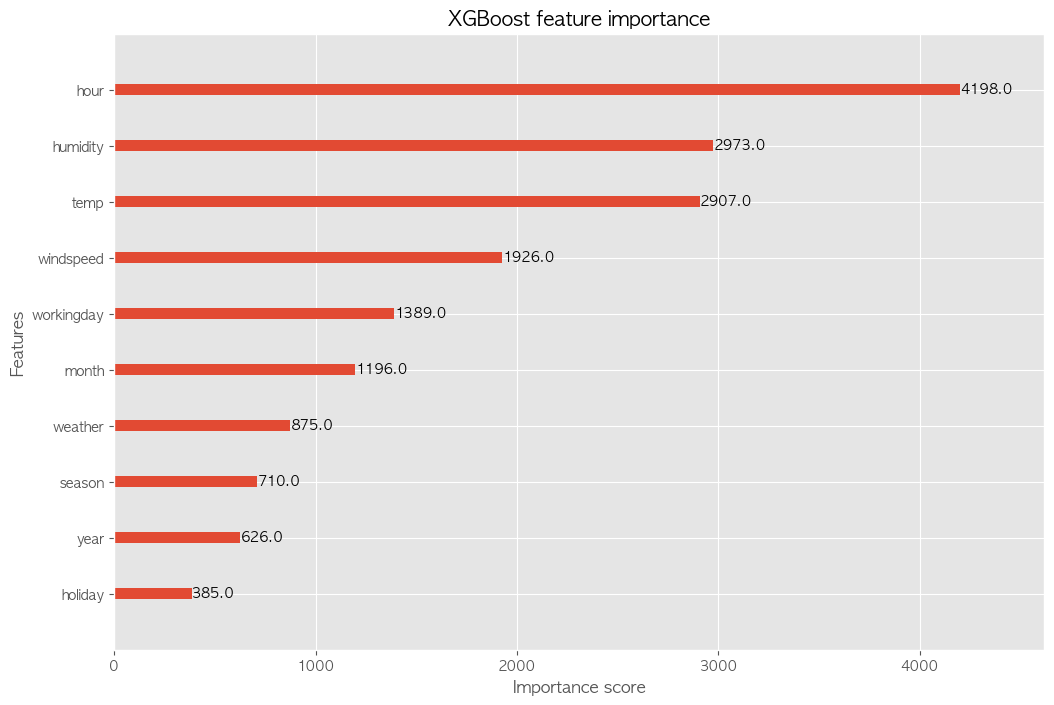

In [32]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_reg, ax=plt.gca())
plt.title('XGBoost feature importance')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = {
    'n_estimators': [500, 1000, 1500, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
}

xgb_reg_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=2,
)

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=xgb_reg_base,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=5,
    verbose=2,
    n_jobs=2,
)

grid_search.fit(X_train, y_train)

print(f"Optimal hyperparameters: {grid_search.best_params_}")
print(f"Optimal evaluation score: {grid_search.best_score_:.4f}")
    

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_